## **LABORATORY 10** - *VGG Finetuning*
#### ANEESH KRISHNA RAMESH - 8914620
---
---

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from keras.preprocessing import image
import seaborn as sb

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
path = pathlib.Path("/content/drive/MyDrive/Jeex/archive")


In [124]:
!pwd

/content


> We have 3 folders, train, test, valid with images different sets of bird species

In [125]:
# trainData = os.path.basename("archive (1)/train")
# testData  = os.path.basename("archive (1)/test")
# validData = os.path.basename("archive (1)/valid")

trainDataPath = os.path.join(path,"train")
testDataPath  = os.path.join(path,"test")
validDataPath = os.path.join(path,"valid")

In [126]:
trainDataPath

'/content/drive/MyDrive/Jeex/archive/train'

In [127]:
def classCount():
    count = {}
    for species in os.listdir(trainDataPath):
        path_species = os.path.join(trainDataPath, species)
        if os.path.isdir(path_species):
            count[species] = len(os.listdir(path_species))
    return count

In [128]:
count = classCount()
sorted_bird_counts = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))
top_3_keys = list(sorted_bird_counts.keys())[:3]
top_3_keys

['RUFOUS TREPE', 'HOUSE FINCH', 'OVENBIRD']

In [129]:
print("Classes available :", count)

Classes available : {'RUFOUS TREPE': 263, 'OVENBIRD': 233, 'HOUSE FINCH': 248}


## **Removing other classes**

In [130]:
# def remove_folder(dir_path):
#     for entry in os.scandir(dir_path):
#         if entry.is_file():
#             os.remove(entry.path)
#         elif entry.is_dir() and entry.name not in top:
#             remove_folder(entry.path)
#             os.rmdir(entry.path)

In [131]:
# remove_folder(trainData)
# remove_folder(testData)
# remove_folder(validData)

## **Classes after removal/Filtering (Only top 3 classes remain)**

In [132]:
print("Classes after filtering top 3 classes :", classCount())

Classes after filtering top 3 classes : {'RUFOUS TREPE': 263, 'OVENBIRD': 233, 'HOUSE FINCH': 248}


In [133]:
train_dataset = image_dataset_from_directory(
    path/"train",
    image_size=(224, 224),
    batch_size=32,
    )

Found 744 files belonging to 3 classes.


## **Augmentation to increase the number of training images**

In [134]:
def imageGeneration(shearRange, zoomRange, fillMode, rotationRange, horFlip):
    return ImageDataGenerator(
    shear_range=shearRange,
    zoom_range=zoomRange,
    fill_mode=fillMode,
    rotation_range=rotationRange,
    horizontal_flip=horFlip,
    # preprocessing_function= keras.applications.vgg16.preprocess_input
    )

imageGen = imageGeneration(0.1, 0.05,'nearest', 0.1, True)
# testImageGen = imageGeneration(0.2, 0.06, 0.2, 'nearest', True)

In [161]:
trainGen = imageGen.flow_from_directory(
    trainDataPath,
    classes=top_3_keys,
    target_size=(224, 224),
    batch_size=32)

Found 744 images belonging to 3 classes.


In [160]:
testGen = imageGen.flow_from_directory(
    testDataPath,
    classes=top_3_keys,
    target_size=(224, 224),
    batch_size=32)

Found 15 images belonging to 3 classes.


In [162]:
validGen = imageGen.flow_from_directory(
    validDataPath,
    classes=top_3_keys,
    target_size=(224, 224),
    batch_size=32)

Found 15 images belonging to 3 classes.


## **Plotting image data**

In [136]:
trainGen.image_shape

(224, 224, 3)

<Figure size 1000x1000 with 0 Axes>

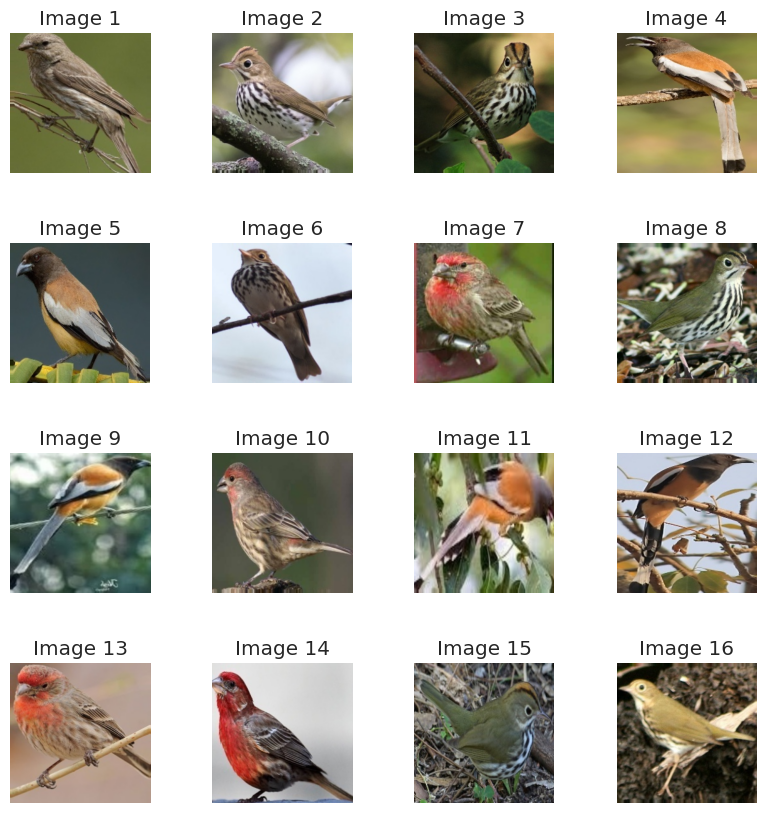

In [159]:
images, _ = next(trainGen)
plt.figure(figsize=(10, 10))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat, start=1):
    ax.imshow(images[i].astype("uint8"))
    ax.set_title(f"Image {i}")
    ax.axis("off")

plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


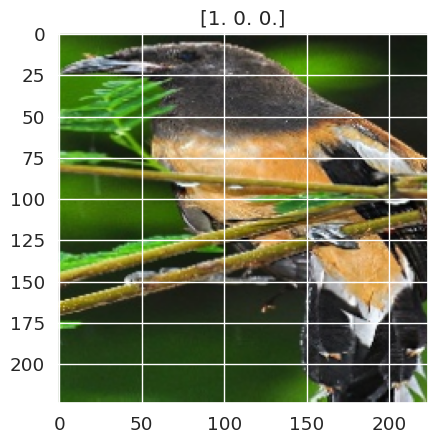

In [138]:
images, labels = next(trainGen)

image = images[1]
image = ((image - image.min()) * (255 / (image.max() - image.min()))).astype(np.uint8)
plt.title(labels[1])
plt.imshow(image)

## **Fine-Tuning using VGG16**

In [139]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [140]:
for layer in base_model.layers[-4:]:
    layer.trainable = True
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

In [141]:
outputs = layers.Dense(len(top_3_keys), activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=outputs)

In [142]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.tf",
        save_best_only=True,
        monitor="val_loss")
]

> #### Had to change convnet_from_scratch.keras to convnet_from_scratch.tf because of versioning

In [143]:
history = model.fit(
    trainGen,
    epochs=15,
    validation_data=validGen,
    callbacks=callbacks)

Epoch 1/15
24/24 [==============================] - 23s 804ms/step - loss: 3.0694 - accuracy: 0.3831 - val_loss: 1.0242 - val_accuracy: 0.5333
Epoch 2/15
24/24 [==============================] - 17s 718ms/step - loss: 0.8988 - accuracy: 0.5887 - val_loss: 0.8732 - val_accuracy: 0.6667
Epoch 3/15
24/24 [==============================] - 17s 711ms/step - loss: 0.5909 - accuracy: 0.7702 - val_loss: 0.8318 - val_accuracy: 0.6000
Epoch 4/15
24/24 [==============================] - 18s 722ms/step - loss: 0.5549 - accuracy: 0.7917 - val_loss: 0.4225 - val_accuracy: 0.8667
Epoch 5/15
24/24 [==============================] - 18s 751ms/step - loss: 0.2644 - accuracy: 0.9113 - val_loss: 0.1353 - val_accuracy: 0.9333
Epoch 6/15
24/24 [==============================] - 17s 710ms/step - loss: 0.1586 - accuracy: 0.9489 - val_loss: 0.0704 - val_accuracy: 1.0000
Epoch 7/15
24/24 [==============================] - 17s 707ms/step - loss: 0.1740 - accuracy: 0.9476 - val_loss: 0.0119 - val_accuracy: 1.0000

## **Plotting Traing vs Validation, Validation Loss**

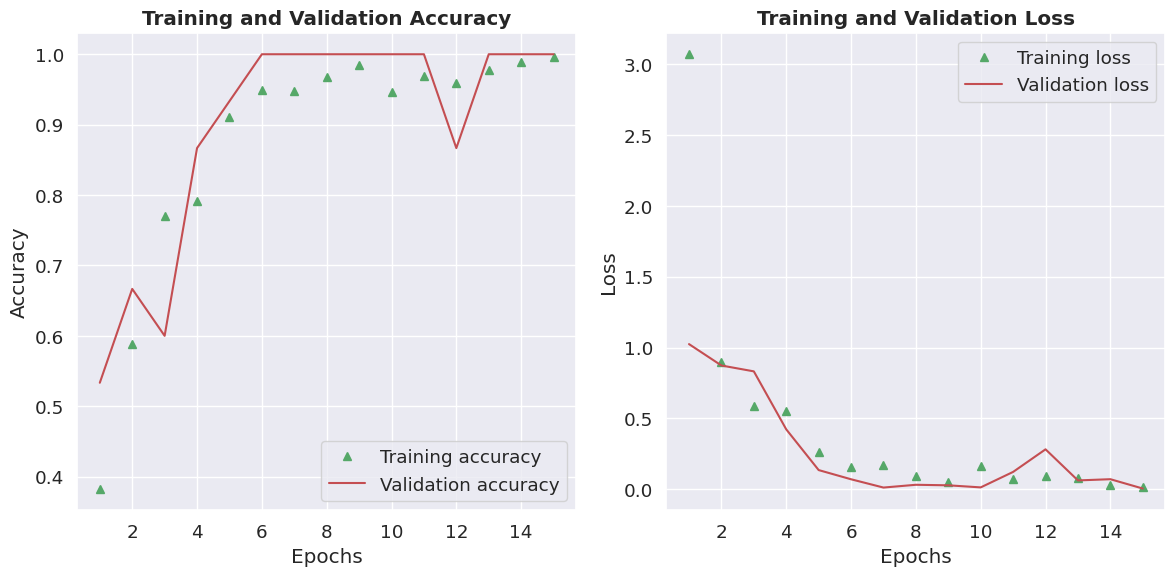

In [144]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "g^", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r-", label="Validation accuracy")
plt.title("Training and Validation Accuracy", fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "g^", label="Training loss")
plt.plot(epochs, val_loss, "r-", label="Validation loss")
plt.title("Training and Validation Loss", fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [145]:
testModel = keras.models.load_model("./models/convnet_from_scratch.tf")
test_loss, test_acc = testModel.evaluate(testGen)

1/1 [==============================] - 1s 720ms/step - loss: 3.4773e-05 - accuracy: 1.0000


In [146]:
print(f"Test accuracy: {test_acc:.2f}")

Test accuracy: 1.00


> A test accuracy of 1.00 (or 100%) indicates that the model has made correct predictions for all the samples in the test dataset. In other words, every image or example in the test set has been classified correctly by the model.

## **Plotting Confusion Matrix**

In [147]:
y_predP = testModel.predict(testGen)
y_pred = np.argmax(y_predP, axis=1)

y_true = testGen.classes

conf_matrix = confusion_matrix(y_true, y_pred)

1/1 [==============================] - 1s 527ms/step


In [148]:
conf_matrix

array([[1, 0, 4],
       [2, 3, 0],
       [2, 3, 0]])

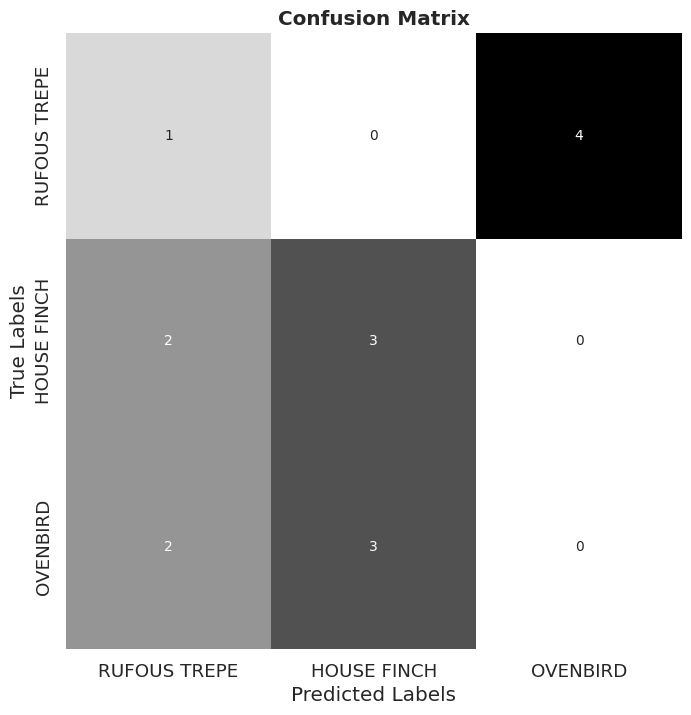

In [149]:
class_labels = list(testGen.class_indices.keys())
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 8))
sb.set(font_scale=1.2)
sb.heatmap(conf_df, annot=True, fmt="d", cmap="Greys", cbar=False, square=True, annot_kws={"size": 10})
plt.title("Confusion Matrix",fontweight='bold')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

> ### **Understanding Confusion matrix :**
> #### This is for 3 different casess : 
> #### - In the first row, the model correctly predicted 1 instance of Class 1, but it incorrectly predicted 4 instances of Class 3 as Class 1.
> #### - In the second row, the model correctly predicted 3 instances of Class 2, but it incorrectly predicted 2 instances of Class 1 as Class 2.
> #### - In the third row, the model did not correctly predict any instances of Class 3, and it incorrectly predicted 3 instances of Class 2 as Class 3.


In [153]:
class_report = classification_report(y_true, y_pred, target_names=testGen.class_indices.keys(), output_dict=True)
formatted_report = {key: f'{value:.3f}' if isinstance(value, (float, np.float64)) else value for key, value in class_report.items()}

report_df = pd.DataFrame(formatted_report).transpose()

In [154]:
print("Formatted Classification Report:\n", report_df)

Formatted Classification Report:
              precision    recall  f1-score support
RUFOUS TREPE       0.2       0.2       0.2     5.0
HOUSE FINCH        0.5       0.6  0.545455     5.0
OVENBIRD           0.0       0.0       0.0     5.0
accuracy         0.267     0.267     0.267   0.267
macro avg     0.233333  0.266667  0.248485    15.0
weighted avg  0.233333  0.266667  0.248485    15.0


> ### "HOUSE FINCH" shows the best performance, while "OVENBIRD" has challenges. Overall accuracy is 26.7%, indicating room for improvement.

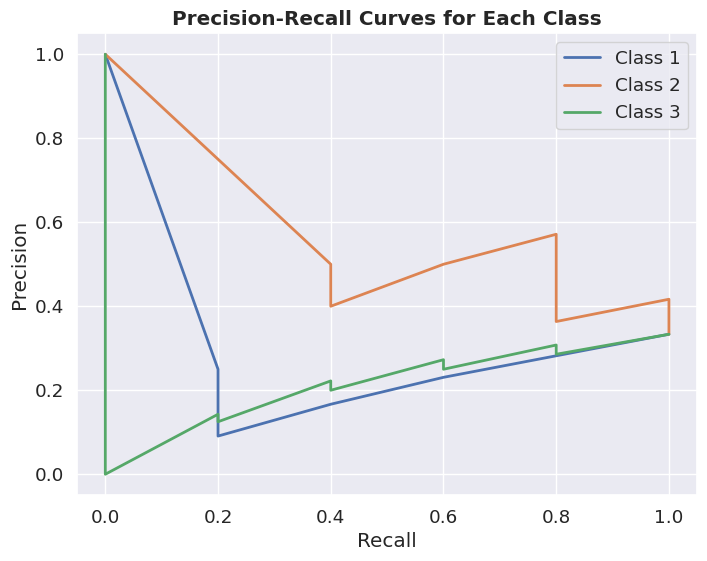

In [151]:
y_true_enc = to_categorical(y_true)

plt.figure(figsize=(8, 6))

for i in range(y_true_enc.shape[1]):
    actual = y_true_enc[:, i]
    predictions = y_predP[:, i]
    precision, recall, _ = precision_recall_curve(actual, predictions)
    plt.plot(recall, precision, lw=2, label=f'Class {i + 1}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curves for Each Class",fontweight='bold')
plt.show()

## **Exmaples of Misclassification**

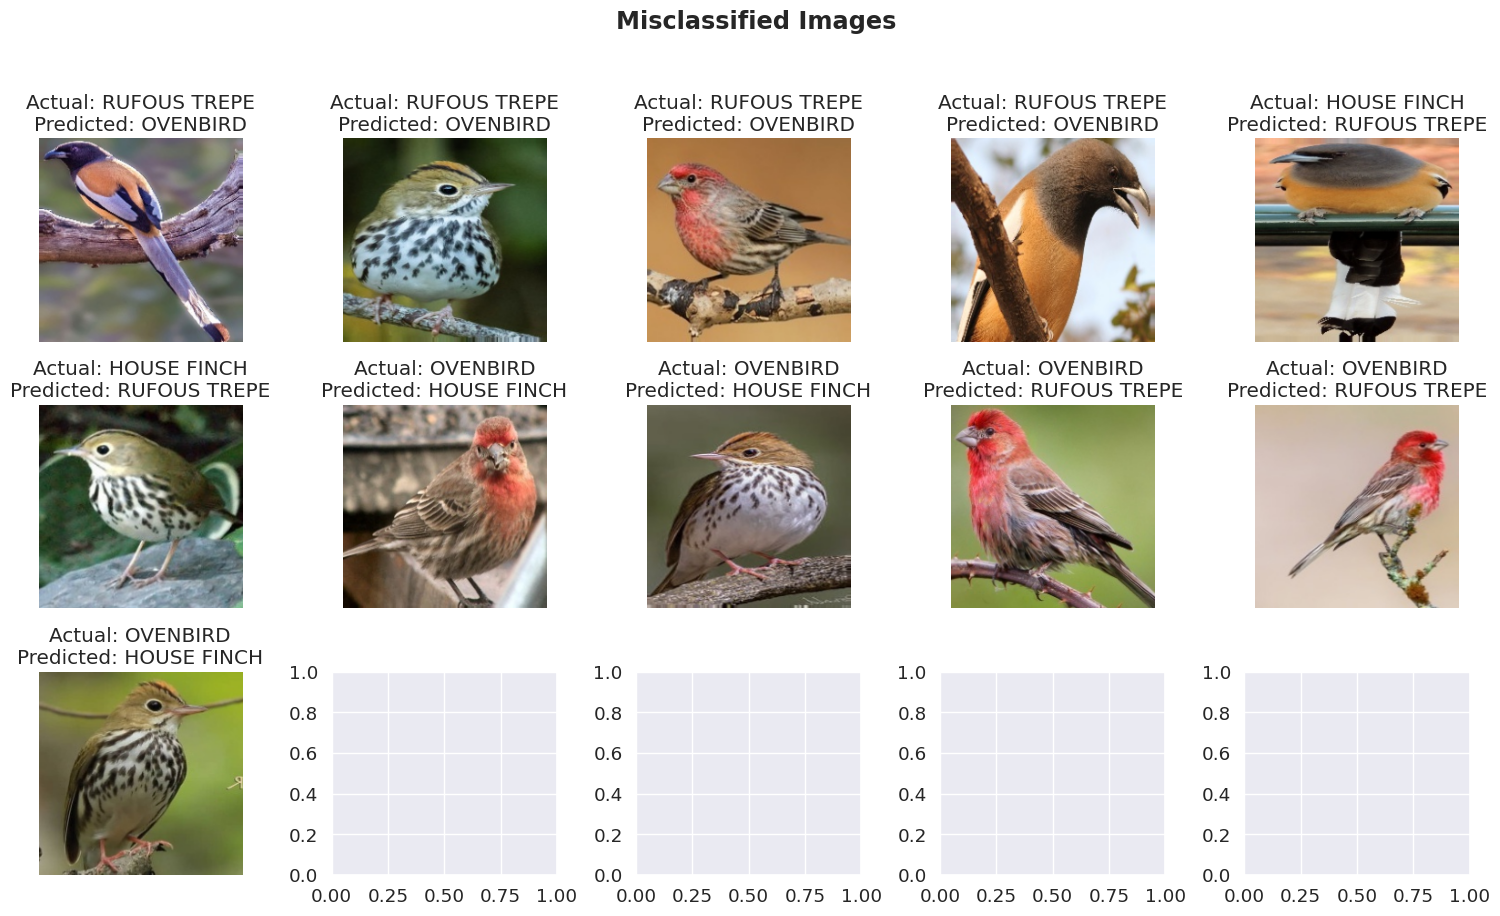

In [152]:
labels = {v: k for k, v in trainGen.class_indices.items()}
misclassified_indices = np.where(y_pred != y_true)[0]

num_plots_per_row = 5
num_rows = (len(misclassified_indices) + num_plots_per_row - 1)

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 3 * num_rows))
fig.suptitle("Misclassified Images", y=1.02, fontweight='bold')

for i, ax in zip(misclassified_indices, axes.flat):
    batch_index, sample_index = divmod(i, testGen.batch_size)
    batch, _ = testGen[batch_index]
    img = batch[sample_index]

    ax.imshow(img.astype("uint8"))
    ax.set_title(f"Actual: {labels[y_true[i]]}\nPredicted: {labels[y_pred[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


> Please ignore the empty plots

## **Observation**

### **Based on the misclassified images, it appears that the initial labels for these samples were incorrect. The species exhibit distinct differences from one another. It is possible that the model predicted it correctly compared to the original labels**